# Part 3 : Restoration

In this part of the TP, we are going to look at image restoration. We will look at several type of noise and ways to remove this noise. We first define some helper functions.

### Your task

In the lab work, you must fill in the code in the places marked FILL IN CODE, or answer the written questions directly on the notebook.

(600, 800)

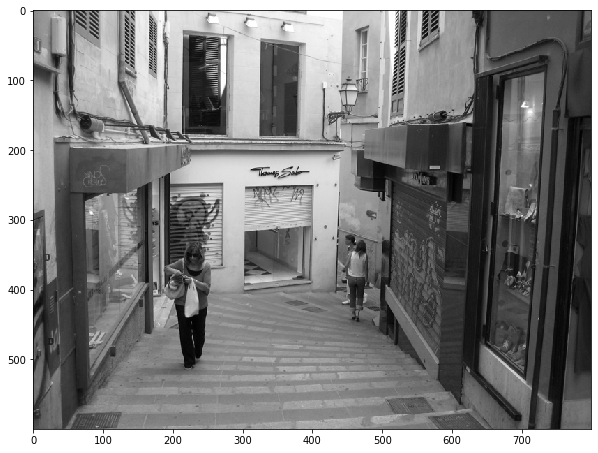

In [0]:
from matplotlib import pyplot as plt
import numpy as np 
import imageio
from skimage import color

def read_image(file_name):
    img_color = imageio.imread(file_name)
    img_gray = color.rgb2gray(img_color)
    return img_gray,img_color
    
def write_image(img_in,file_name_out):
    imageio.imwrite(file_name_out, np.uint8(255.0*img_in))
    
def display_image(img_in):
    plt.figure(figsize=(10, 10))
    if (img_in.ndim == 2):
        plt.imshow(img_in,cmap='gray')
    elif (img_in.ndim == 3):
        # careful, in this case we supppose the pixel values are between 0 and 255
        plt.imshow(np.uint8(img_in))
    else:
        print('Error, unknown number of dimensions in image')
    return

file_dir = 'images/'
file_name = 'palma'
file_ext = '.png'
img_gray,_ = read_image(file_dir+file_name+file_ext)
display_image(img_gray)
img_gray.shape

We will look at the following noise types :

- Gaussian noise
- Impulse (salt-and-pepper, 0 or 1) noise
- Missing pixels

Fill in the following functions to add this noise to a gray-level image. Do not forget to clip the pixe values to the range $(0,1)$ (np.clip).

In [0]:
def add_gaussian_noise(img_in,sigma_noise = 0.01):

    
    row,col= img_in.shape
    gauss = np.random.normal(0,sigma_noise,(row,col))
    gauss = gauss.reshape(row,col)

    noisy = img_in + gauss
    return np.clip(noisy, 0, 1) 

# we define the impulse probability p as the probability of a pixel not being affected
def add_impulse_noise(img_in,p=0.9):
    out=img_in.copy()
    for i in range(img_in.shape[0]):
      for j in range(img_in.shape[1]):
        if int(np.random.choice([0,1], 1, p=[1-p,p])) == 0:
           out[i,j]=int(np.random.choice([0,1], 1, p=[0.5, 0.5]) )
       
    return out

def add_missing_pixels_noise(img_in,p=0.9):
    out=img_in.copy()
    for i in range(img_in.shape[0]):
      for j in range(img_in.shape[1]):
        out[i,j]*=int(np.random.choice([0,1], 1, p=[1-p,p]) )

    return out

Add the different noises to the input image, and display (or write) the results. Use the following parameters :

- sigma_noise=0.05 for the gaussian noise
- $p=0.9$ (the probability of a pixel __not__ being affected, for the impulse noise and missing pixels

In [0]:
sigma_noise = 0.05
img_gray_gaussian = add_gaussian_noise(img_gray, sigma_noise)
write_image(img_gray_gaussian,file_name+'_gaussian_noise.png')

img_gray_impulse = add_impulse_noise(img_gray, 0.9)
write_image(img_gray_impulse,file_name+'_impulse_noise.png')

img_gray_missing = add_missing_pixels_noise(img_gray, 0.9)
write_image(img_gray_missing,file_name+'_missing_pixels.png')

__Question__ For each type of noise, propose a restoration filter (see course slides).

__Answer__ 

**Gaussian noise** generally happens in the analog signal in the electronicsof the camera

Can be modelled as additive noise :
\begin{equation} 
y=I+\sigma \eta
\end{equation} 
Where $\eta \sim \mathcal{N}(0,1)$,and $ \sigma$   is the standard deviation of the noise.

**Gaussian noise**, is often **removed** using a smoothing filter :

    Gaussian filter 
 


**Impulse noise** corresponds to random pixels which are either saturated (1) or turned off (0).Can happen in equipment with electronic spikes We can model this as :

\begin{equation} 
y=\left\{\begin{matrix}
I & \text{with probability p}  \\ 
b &  \text{with probability 1-p} 
\end{matrix}\right.
\end{equation}

Where $b \sim \mathcal{B}(\frac{1}{2})$.

**Missing pixels**  can happen when certain pixels in a display are notfunctioningCan be modelled as :

\begin{equation} 
y=Ib
\end{equation} 

Where $b \sim \mathcal{B}(p)$.


If only a few pixels are likely to be damaged, then the **median filter** is a good option for the following types of noise :

    Impulse noise
    Random missing pixels


Implement these restoration filters in appropriately named functions, and write the corresponding output images. Try to find the parameters which give the best results (visually).

__IMPORTANT NOTE__, you can use the filtering functions of the ``scipy.ndimage`` package, where the filtering is already implemented (do not re-implement the filters)

In [0]:
from scipy import ndimage
import cv2
# FILL IN CODE : CREATE THE FUNCTIONS TO CARRY OUT THE RESTORATION FILTERS AND WRITE THE RESULTS
def median_filter(img,size=(3,3)):
  return  ndimage.median_filter(img, size)
def gaussian_filter(img,sigma=2,w=3):
  t = (((w - 1)/2)-0.5)/sigma
  return ndimage.filters.gaussian_filter(img, sigma=sigma, truncate=t)


In [0]:
clean_img_gray_gaussian = gaussian_filter(img_gray_gaussian,sigma=2,w=3)
write_image(clean_img_gray_gaussian,file_name+'_Restored_gaussian_noise.png')

clean_img_gray_impulse = median_filter(img_gray_impulse,size=(3,3))
write_image(clean_img_gray_impulse,file_name+'_Restored_impulse_noise.png')

clean_img_gray_missing = median_filter(img_gray_missing,size=(3,3))
write_image(clean_img_gray_missing,file_name+'_Restored_missing_pixels.png')

In [0]:
from sklearn.metrics import mean_squared_error
mean_squared_error(clean_img_gray_gaussian,img_gray_gaussian)

0.0031319671375477087

__Question__ Roughly speaking, what is the tradeoff which you are trying to achieve by tuning the parameters ?

__Answer__

The **effectiveness** of most **image processing** algorithms de-pends  on  a  careful  **parameter  choice**.   For  instance,  denoising methods commonly require a **denoising strengthor** a **patch size** to be set.  These parameters can be adjusted per image, but neglect-ing  the  local  image  characteristics  leads  to  **sub-optimal  results**.Setting the filtering parameters adaptively has obvious benefits; e.g., the denoising strength can be higher in smooth areas wherethe risk of blurring out details is low, and in turn it can be lower in highly textured areas where noise is less visible. Adaptiveness can also be easily achieved by mixing the output of different al-gorithms, each operating at best in a different part of an image.

### Evaluation

A commonly used metric for denoising is the ''Peak Signal-to-Noise Ratio'' (PSNR). This is linked to the commonly known mean squared error. The mean squared error is defined, for a reference image $Y$ and a restored image $Y$, of size $m \times n$ as :

- MSE$(Y,I) = \frac{1}{mn} \sum_{x,y} \left( I_{x,y} - Y_{x,y}\right)^2 $

The PSNR is defined, in Decibels, as :

PSNR$(Y,I) = 10 * \log{\left( \frac{I_{max}^2}{MSE(Y,I)} \right)}$,

where $I_{max}$ is the maximum value of the image. For us (normalised to 1), this gives :

PSNR$(Y,I) = -10 * \log{ \left({MSE(Y,I)} \right)}$.

Implement this in a function, and create a code to plot the PSNR for several values of the paramter, __in the Gaussian case only (first filter)__. 

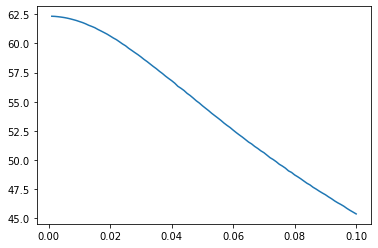

In [0]:
from sklearn.metrics import mean_squared_error
def PSNR(img,img_ref):
    # FILL IN CODE
    I=img_ref.copy()
    Y=img.copy()
    mse=mean_squared_error(Y,I)
    psnr=-10*np.log(mse)

    return psnr

# FILL IN CODE : TEST THE PSNR FOR SEVERAL VALUES OF SIGMA
result=[]
for sigma in np.linspace(0.001, 0.1, 100):
  img=add_gaussian_noise(img_gray, sigma)
  img_ref=gaussian_filter(img,sigma=2,w=5)
  result.append(PSNR(img,img_ref))
plt.plot(np.linspace(0.001, 0.1, 100),result)

## POUR ALLER PLUS LOIN (PARTIE PAS OBLIGATOIRE)

## Deconvolution

In this part of the TP, we are going to try and invert a convolution operation. This is called __deconvolution__, and can be carried out in the Fourier domain, as follows. For an image $I$, filter $f$ and an output $Y$, if we have :

$Y = I \ast f$,

then using the convolution theorem (see lesson), we have :

$I = \text{IFFT}\left(\frac{\hat{Y}}{\hat{f}}\right)$

where $\hat{Y}$ and $\hat{f}$ are the Fourier transforms of $Y$ and $f$ respectively.

To simplify the problem, we take a square image for this part of the TP.


(600, 600)

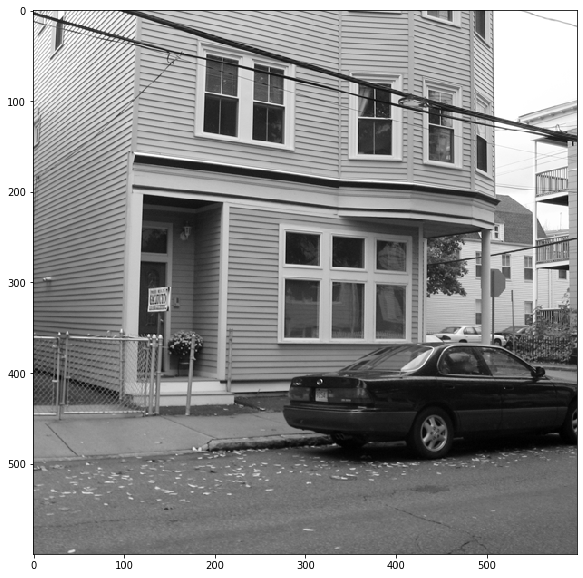

In [0]:
file_dir = 'images/'
file_name = 'boston'
file_ext = '.png'
img_gray,_ = read_image(file_dir+file_name+file_ext)
display_image(img_gray)
img_gray.shape

Now, let us consider the following fiter, defined in the Fourier domain :

(600, 600)


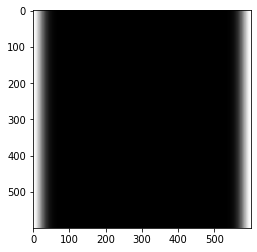

In [0]:
from scipy import signal

img_size = img_gray.shape[0]
h_size = int(np.floor(img_size/2.0))
f_hat = np.zeros((img_size,img_size))

X = np.asarray(range(-h_size,h_size))
f_hat = np.tile( np.expand_dims( np.exp(-( X**2) / (2.0*(20.0**2))) , axis=1), (1,img_size)).T
f_hat /= f_hat.sum()
f_hat = np.fft.ifftshift(f_hat)
plt.imshow( np.log( np.abs(f_hat)+1), cmap = 'gray')

print(f_hat.shape)

Using the convolution theorem and the inverse Fourier transform, carry out the convolution of the input image with $f$ (in the Fourier domain, so using $\hat{f}$) and write the result ``img_convolved`` to an output file

__Question__ What does this filter do (you can use the visualisation method from the first part of the TP to see what the filter spectrum looks like) ? __Bonus__ How can this happen in real life ? 

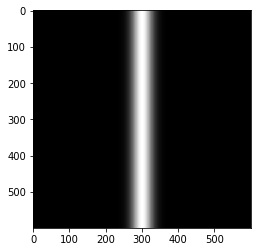

In [0]:
plt.imshow(np.fft.fftshift(f_hat),cmap='gray')

The **Motion Blur** filter creates a movement blur. The filter is capable of Linear, Radial, and Zoom movements. Each of these movements can be further adjusted, with Length, or Angle settings available. 

![alt text](https://hsto.org/storage2/5fe/116/30f/5fe11630f207472c4d2801e1d9c82483.png)

**Motion blur** in a photograph occurs when either the object being photographed or the camera itself moves while the camera shutter is open. If this motion is linear and uniform over time,then in the spatial domain, the blurring filter may be considered simply a white straight line in a black background, since the motion is linear in one dimension and uniform. Of course the motion may be at an angle relative to horizontal and thus the line would be oriented at some angle. The length of the line corresponds directly to the amount of motion blurring.



Restoration of distorted images is one of the most interesting and important problems of image processing - from the theoretical, as well as from the practical point of view.


Motion blurin images is usually modeled as the convolution of a point spread function(PSF)and the original image represented as pixel intensities.**Motion blur Filter** function can be used to model various types of motion-blurs,and hence it allows for the construction of a PSF and accurate estimation of the degradation function without knowledge of the specific degrada-tion model.

In [0]:
def filter_image(img,f_hat):
    y=f_hat.copy()

    x=img.copy()
    new_x = np.fft.fft2(x)
    tmp=new_x*y
    img_out = np.abs(np.fft.ifft2(tmp))

    
    return(img_out)

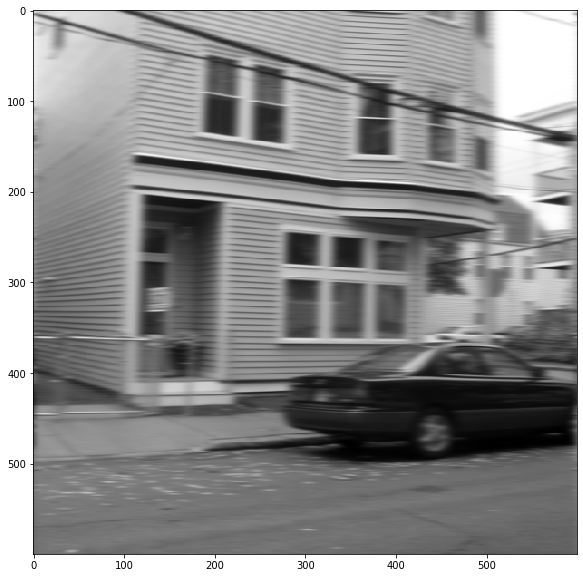

In [0]:
img_convolved =filter_image(img_gray,f_hat) # FILL IN CODE
img_convolved=(img_convolved-img_convolved.min())/(img_convolved.max()-img_convolved.min())
write_image(img_convolved,file_name+'_convolution.png')
display_image(img_convolved)

__Answer__ 

Now, create a function which carries out a deconvolution in the Fourier domain, given an image and the Fourier transform of the filter $\hat{f}$. You can reuse the code in the first part of the TP. Carry out the deconvolution on ``img_convolved`` and write the result to an output file. Remember to renormalise the output image.

__Important note__ : You will have a problem with very small values of $\hat{f}$ (division by 0). Propose a simple method to address this issue.


In [0]:
def deconvolve_fourier(img,f_hat):
    result=img.copy()
    y=f_hat.copy()
    img_out = np.abs(np.fft.ifft2(np.fft.fft2(result) /(y+0.0000001) ))
    return img_out
    

img_out = np.real(deconvolve_fourier(img_convolved,f_hat))
img_out=(img_out-img_out.min())/(img_out.max()-img_out.min())


write_image(img_out,file_name+'_deconvolved.png')

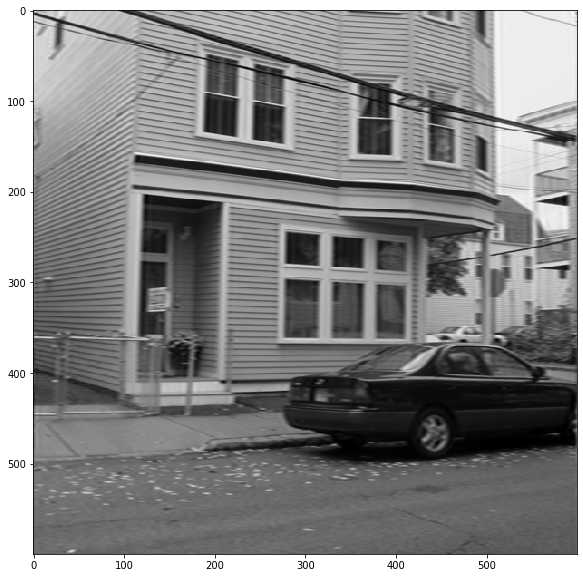

In [0]:
display_image(img_out)